In [1]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp
import warnings
import orjson as json
warnings.filterwarnings("ignore")

In [2]:
with open('passed.txt') as f:
    tickers = f.read().splitlines()
tickers.append('^TNX')  # 10 year treasury yield
with open('ticker_capm.json') as f:
    ticker_capm = json.loads(f.read())
ticker_info = pd.read_csv('yahoo_tickers.csv')
MAR = 0.118  # see calc_r.txt

In [3]:
def download_data_and_calc_returns(tickers, period='5y', interval='1d', prepost=False):
    if isinstance(tickers, list):
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:,('Adj Close', slice(None))]  # get adjusted close only
        data.columns = tickers
        data['WYN.L']['2022-06-14'] = 628.0  #TODO: manually fix yahoo data wrong
        data = data[tickers].pct_change().dropna()
        return data
    else:
        data = yf.download(tickers, period=period, interval=interval, prepost=prepost, threads=True)
        data = data.loc[:, 'Adj Close']
        data = data.pct_change().dropna()
        return data

returns = download_data_and_calc_returns(tickers)
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
returns = returns.sum(level=0)  # merge 2 days into 1 since different market has diff closing time

[*********************100%***********************]  63 of 63 completed


In [4]:
nasdaq_returns = download_data_and_calc_returns('^IXIC', period='10y')
nasdaq_slpm = rp.RiskFunctions.LPM(nasdaq_returns, MAR=MAR/252, p=2)

[*********************100%***********************]  1 of 1 completed


In [5]:
port = rp.Portfolio(returns=returns, sht=False, lowerret=MAR/252, upperslpm=round((nasdaq_slpm)*(252**(1/2)), 2)/(252**(1/2)))
#round((nasdaq_slpm*0.6)*(252**(1/2)), 2)/(252**(1/2))

In [6]:
method_to_estimate_expected_return = 'ewma1'  # useless, will be overridden with custom returns
method_to_estimate_covariance = 'hist'
port.assets_stats(method_mu=method_to_estimate_expected_return, method_cov=method_to_estimate_covariance, d=0.99)  # lower d means place more emphasis on recent performance, 0 <= d < 1

In [7]:
port.mu['^TNX'] = 0.04/252  # set risk free asset

In [35]:
def custom_returns(col):
    if col.name != '^TNX':
        return pd.Series([ticker_capm[col.name] / (252*100)])
    else:
        return col
port.mu = port.mu.apply(custom_returns, axis=0)
port.mu*252

,000333.SZ,000858.SZ,300760.SZ,600007.SS,600519.SS,ABT,AFL,ALL,AMD,AMZN,...,TSLA,UAA,ULTA,UNH,VEEV,WDFC,WMT,WSM,WYN.L,^TNX
0,0.075,0.084,0.064,0.08,0.076,0.071,0.08,0.079,0.084,0.089,...,0.085,0.103,0.074,0.069,0.068,0.073,0.076,0.082,0.1,0.04


In [16]:
assets = port.mu.columns.values.tolist()

model = 'Classic'  # based on history
risk_measure = 'SLPM'  # Sortino Ratio
obj = 'MinRisk'
risk_free_rate = MAR/252  # MAR converted to daily

#w = port.optimization(model=model, rm=risk_measure, obj=obj, rf=risk_free_rate)
with open('pp.txt') as f:
    weights = f.read().splitlines()
weights = list(map(lambda x: float(x), weights))
weights = [w*1/np.sum(weights) for w in weights]
base = {'tick': assets, 'weights': weights}
w = pd.DataFrame(base).set_index('tick')
ax = rp.plot_pie(w=w, title=f'{risk_measure} {obj}', others=0.01, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

In [17]:
#multiplier[port.assetslist.index('CIPLA.BO')] = 0.6
#multiplier[port.assetslist.index('ECLERX.BO')] = 0.5
#multiplier[port.assetslist.index('INFY.BO')] = 0.5
multiplier[port.assetslist.index('NVDA')] = 1.25
multiplier[port.assetslist.index('JPM')] = 1.25
#multiplier[port.assetslist.index('WMT')] = 0.8
#multiplier[port.assetslist.index('MET')] = 0.7
#multiplier[port.assetslist.index('HSBA.L')] = 0.9
#multiplier[port.assetslist.index('BBSE3.SA')] = 0.5


#multiplier[port.assetslist.index('AMZN')] = 1.1
multiplier[port.assetslist.index('TR')] = 0.7
multiplier[port.assetslist.index('NTES')] = 0.5
#multiplier[port.assetslist.index('TCS.BO')] = 0.5
#multiplier[port.assetslist.index('FFH.TO')] = 0.5
#multiplier[port.assetslist.index('SDR.L')] = 0.5
#multiplier[port.assetslist.index('LMT')] = 0.5
#multiplier[port.assetslist.index('WYN.L')] = 0.5

print(multiplier)
port.mu = np.multiply(port.mu,multiplier)
port.mu*252

[1, 1, 1, 1, 1.1, 1, 1, 1, 0.5, 1, 0.6, 1, 1, 1, 1, 0.5, 1, 0.5, 1, 1, 1, 1, 0.9, 0.5, 1, 1.25, 1, 0.5, 1, 1, 0.7, 1, 1, 1, 1, 1, 1.25, 1, 1, 1, 1, 1, 0.5, 1, 0.5, 0.7, 1, 1, 1, 1, 1, 1, 1, 1, 0.8, 1, 0.5, 1]


In [12]:
asset_classes = {'Assets': assets,
                 'Industry': [ticker_info.loc[ticker_info['Ticker'] == ticker]['GICS Sector'].to_list()[0] for ticker in assets[:-1]]+['Treasury'],
                 'Country': [ticker_info.loc[ticker_info['Ticker'] == ticker]['Country'].to_list()[0] for ticker in assets[:-1]]+['NA'],
                 'n': ['Yes' if asset == 'NVDA' else 'No' for asset in assets],
                 'c': ['Yes' if asset == 'CIPLA.BO' else 'No' for asset in assets]}
asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])
asset_classes

,Assets,Industry,Country,n,c
0,000333.SZ,Consumer Discretionary,China,No,No
1,000858.SZ,Consumer Staples,China,No,No
2,300760.SZ,Health Care,China,No,No
3,600007.SS,Real Estate,China,No,No
4,600519.SS,Consumer Staples,China,No,No
...,...,...,...,...,...
58,WDFC,Consumer Staples,US,No,No
59,WMT,Consumer Staples,US,No,No
60,WSM,Consumer Discretionary,US,No,No
61,WYN.L,Consumer Staples,UK,No,No


In [31]:
views = pd.read_csv('views.csv')
views.fillna('', inplace=True)
views

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,False,Classes,Industry,Health Care,>=,0.10,Classes,Industry,Industrials
1,False,Classes,Industry,Consumer Staples,>=,0.05,Classes,Industry,Consumer Discretionary
2,False,Classes,Industry,Information Technology,>=,0.10,Classes,Industry,Consumer Staples
3,False,Classes,Country,US,>=,0.10,Classes,Country,India
4,False,Assets,,NVDA,>=,0.20,Classes,Industry,Information Technology
5,False,Assets,,JPM,>=,0.10,Classes,Industry,Financials
6,False,Classes,Country,US,>=,0.50,Classes,Country,Brazil
7,False,Classes,Country,US,>=,0.10,Classes,Country,China
8,False,Classes,Country,US,>=,0.50,Classes,Country,Canada
9,False,Classes,Country,US,>=,0.10,Classes,Country,UK


In [32]:
P, Q = rp.assets_views(views, asset_classes)

pd.DataFrame(P.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,-0.1,0.0,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.1,-0.1,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
2,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.166667,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.1,-0.1,0.000000,0.0,0.0,0.000000,-0.200000,0.000000,0.000000,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000000,0.1,-0.1,0.022222,0.0,0.0,0.022222,0.022222,0.022222,0.022222,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
59,0.000000,0.1,-0.1,0.022222,0.0,0.0,0.022222,0.022222,0.022222,0.022222,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0
60,0.000000,-0.1,0.0,0.022222,0.0,0.0,0.022222,0.022222,0.022222,0.022222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
61,0.000000,0.1,-0.1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.250000,0.1,0.0,0.0,0.0,0.000000,0.0,-0.1,0.0


In [33]:
port.blacklitterman_stats(P, Q/252, rf=risk_free_rate, w=w, delta=None, eq=True)
model='BL'
rm = 'SLPM'
obj = 'Sharpe'
hist = True
w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=risk_free_rate, hist=hist)
w_bl.T

,000333.SZ,000858.SZ,300760.SZ,600007.SS,600519.SS,ABT,AFL,ALL,AMD,AMZN,...,TSLA,UAA,ULTA,UNH,VEEV,WDFC,WMT,WSM,WYN.L,^TNX
weights,4.841263e-10,0.022288,0.074481,1.191236e-10,0.03188,0.064812,9.392067e-12,0.010491,2.619359e-11,1.624070e-11,...,0.01562,3.195404e-11,1.425750e-11,2.143195e-11,0.065341,0.014809,3.336508e-11,0.003934,0.067261,3.977450e-12


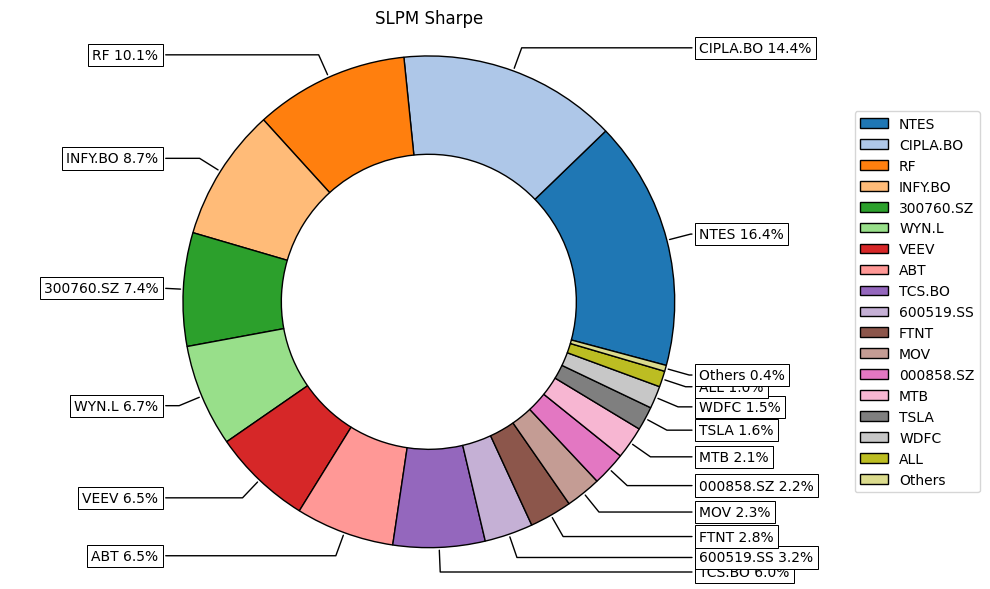

In [36]:
ax = rp.plot_pie(w=w_bl, title=f'{risk_measure} {obj}', others=0.01, nrow=len(port.assetslist), cmap="tab20", height=6, width=10, ax=None)

array([<AxesSubplot: title={'center': 'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot: title={'center': 'Portfolio Composition'}>,
       <AxesSubplot: title={'center': 'Risk (Second Lower Partial Moment) Contribution per Asset'}>,
       <AxesSubplot: title={'center': 'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

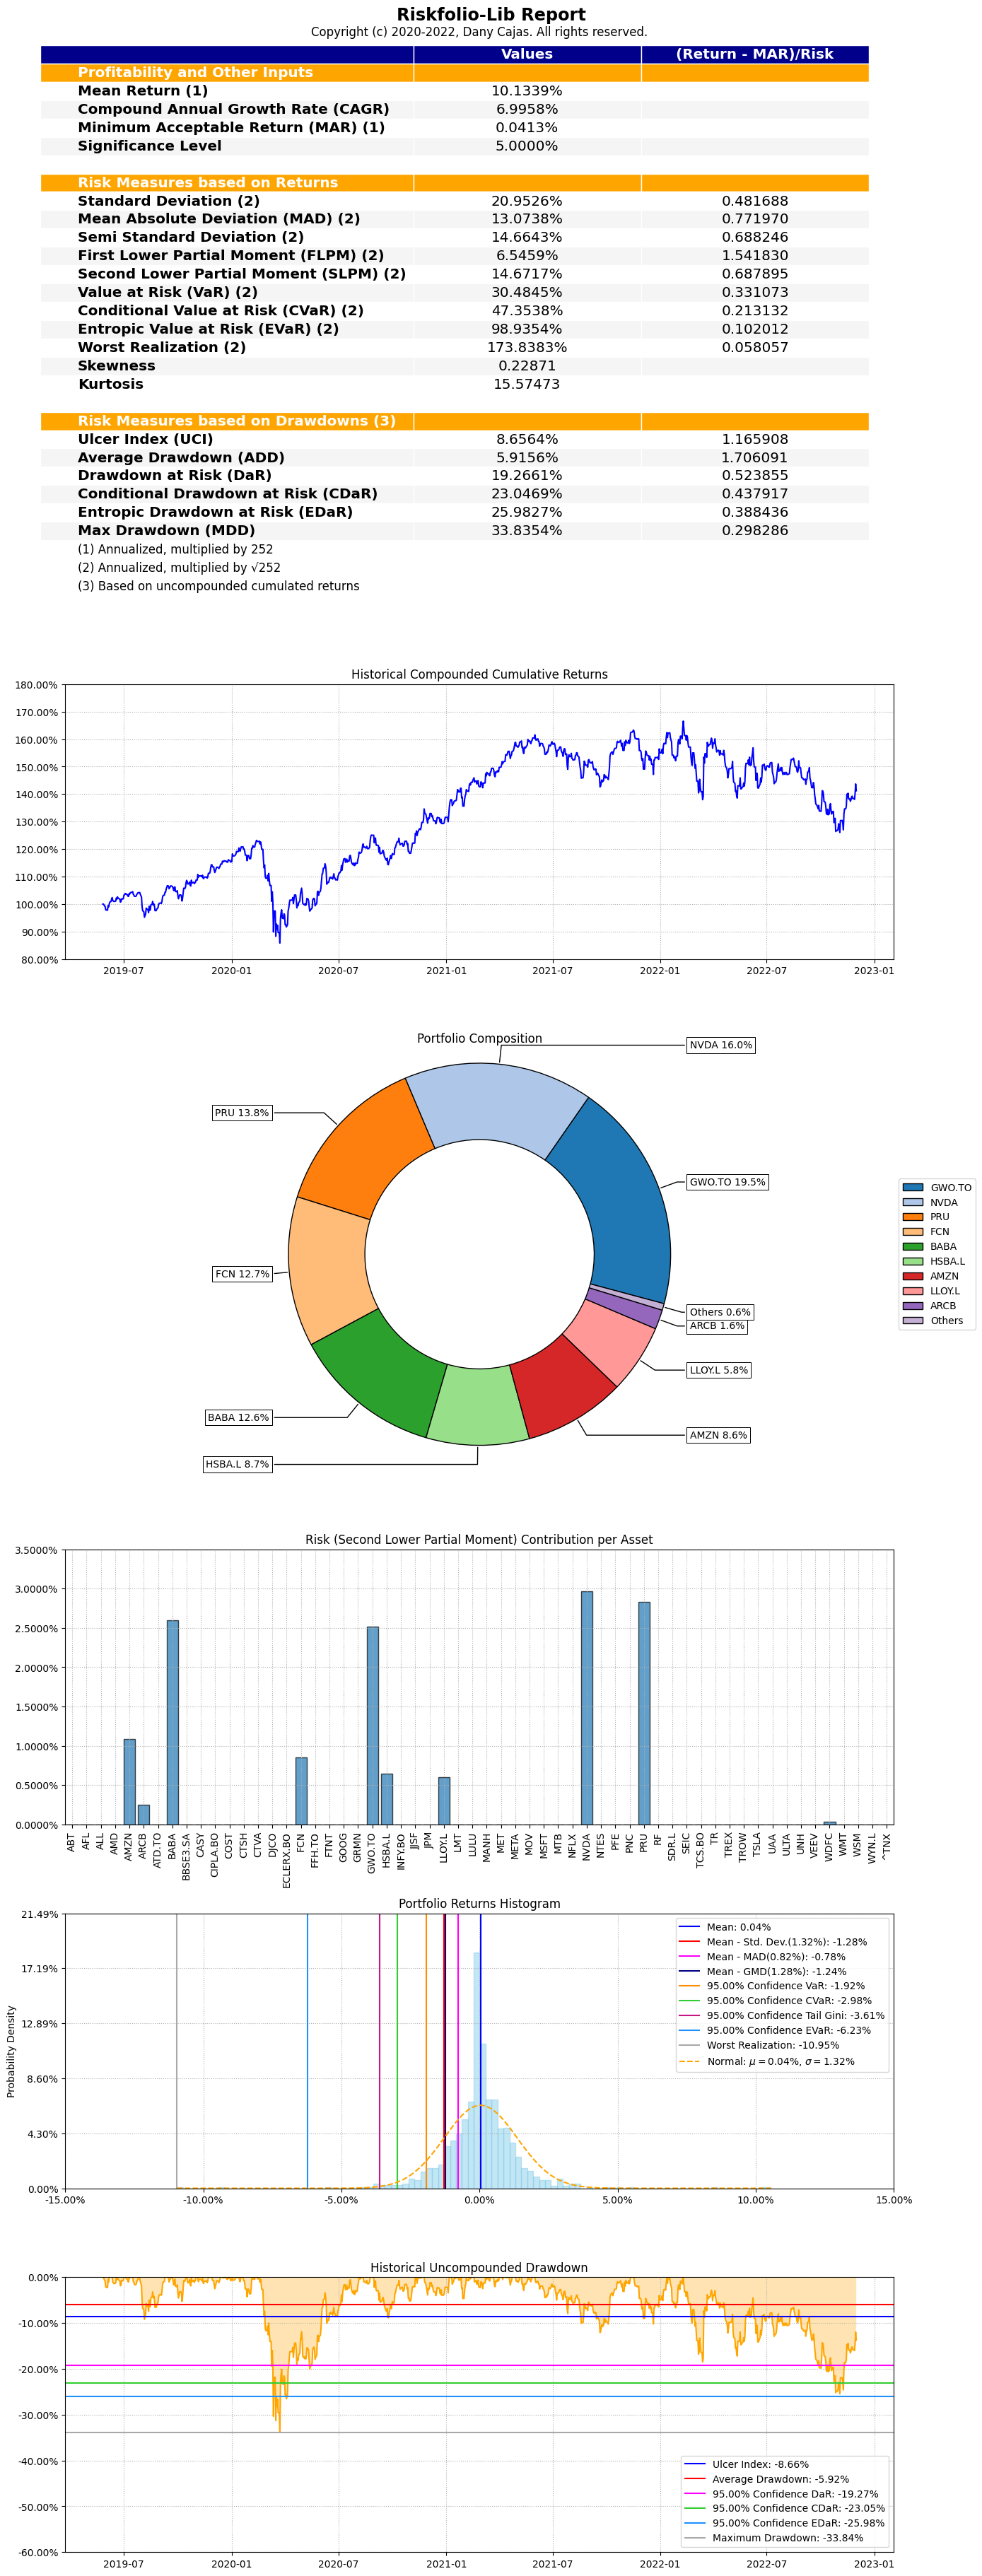

In [14]:
returns.index = returns.index.map(lambda a: pd.to_datetime(a).date())  # remove timezone awareness by converting to dates only
rp.Reports.excel_report(returns, w, rf=risk_free_rate, alpha=0.05, t_factor=252, ini_days=1, days_per_year=252, name='portfolio_report')
rp.Reports.jupyter_report(returns, w, rm=risk_measure, rf=risk_free_rate, alpha=0.05, others=0.01, nrow=len(port.assetslist), height=6, width=14, t_factor=252, ini_days=1, days_per_year=252, bins=100)

In [15]:
w.round(8)*100

,weights
ABT,0.000000
AFL,0.000000
ALL,0.000000
AMD,0.000000
AMZN,8.570883
ARCB,1.644059
ATD.TO,0.000000
BABA,12.636270
BBSE3.SA,0.000000
CASY,0.000000
